## Fontes:

* Código: https://www.kaggle.com/code/nirmalvignu/bags-classification-using-resnet50-99-accuracy

* Dataset: https://www.kaggle.com/datasets/mostafaabla/garbage-classification?resource=download

## Bibliotecas

In [1]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path
import glob

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools


## Importar algumas funções

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2024-01-23 06:47:03--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-01-23 06:47:03 (72.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Conjunto de dados

In [3]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# deixo comentado p/não descompactar de novo quando executo o código inteiro.
# se for a primeira vez, é necessário descompactar o arquivo,
# portanto deve-se rodar esta célula com o comando abaixo descomentado.

#!unzip 'drive/My Drive/CPQD/05_bag/BagClasses.zip' -d 'drive/MyDrive/CPQD/05_bag/'

In [4]:
#dataset = "drive/My Drive/CPQD/05_bag/Bag Classes/"
dataset = "drive/My Drive/CPQD/04_tiagoJK/garbage_classification/"
walk_through_dir(dataset)

There are 12 directories and 0 images in 'drive/My Drive/CPQD/04_tiagoJK/garbage_classification/'.
There are 0 directories and 945 images in 'drive/My Drive/CPQD/04_tiagoJK/garbage_classification/battery'.
There are 0 directories and 985 images in 'drive/My Drive/CPQD/04_tiagoJK/garbage_classification/biological'.
There are 0 directories and 607 images in 'drive/My Drive/CPQD/04_tiagoJK/garbage_classification/brown-glass'.
There are 0 directories and 891 images in 'drive/My Drive/CPQD/04_tiagoJK/garbage_classification/cardboard'.
There are 0 directories and 5325 images in 'drive/My Drive/CPQD/04_tiagoJK/garbage_classification/clothes'.
There are 0 directories and 629 images in 'drive/My Drive/CPQD/04_tiagoJK/garbage_classification/green-glass'.
There are 0 directories and 769 images in 'drive/My Drive/CPQD/04_tiagoJK/garbage_classification/metal'.
There are 0 directories and 1050 images in 'drive/My Drive/CPQD/04_tiagoJK/garbage_classification/paper'.
There are 0 directories and 865 im

In [5]:
Path(dataset)

PosixPath('drive/My Drive/CPQD/04_tiagoJK/garbage_classification')

In [6]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [7]:
image_df

,Filepath,Label
0,drive/My Drive/CPQD/04_tiagoJK/garbage_classif...,battery
1,drive/My Drive/CPQD/04_tiagoJK/garbage_classif...,battery
2,drive/My Drive/CPQD/04_tiagoJK/garbage_classif...,battery
3,drive/My Drive/CPQD/04_tiagoJK/garbage_classif...,battery
4,drive/My Drive/CPQD/04_tiagoJK/garbage_classif...,battery
...,...,...
15510,drive/My Drive/CPQD/04_tiagoJK/garbage_classif...,white-glass
15511,drive/My Drive/CPQD/04_tiagoJK/garbage_classif...,white-glass
15512,drive/My Drive/CPQD/04_tiagoJK/garbage_classif...,white-glass
15513,drive/My Drive/CPQD/04_tiagoJK/garbage_classif...,white-glass


[11547  8720  1863  4216 11958  2681 12577 13070  9399 15461  5848  3906
 14236 14051  4892  1464]


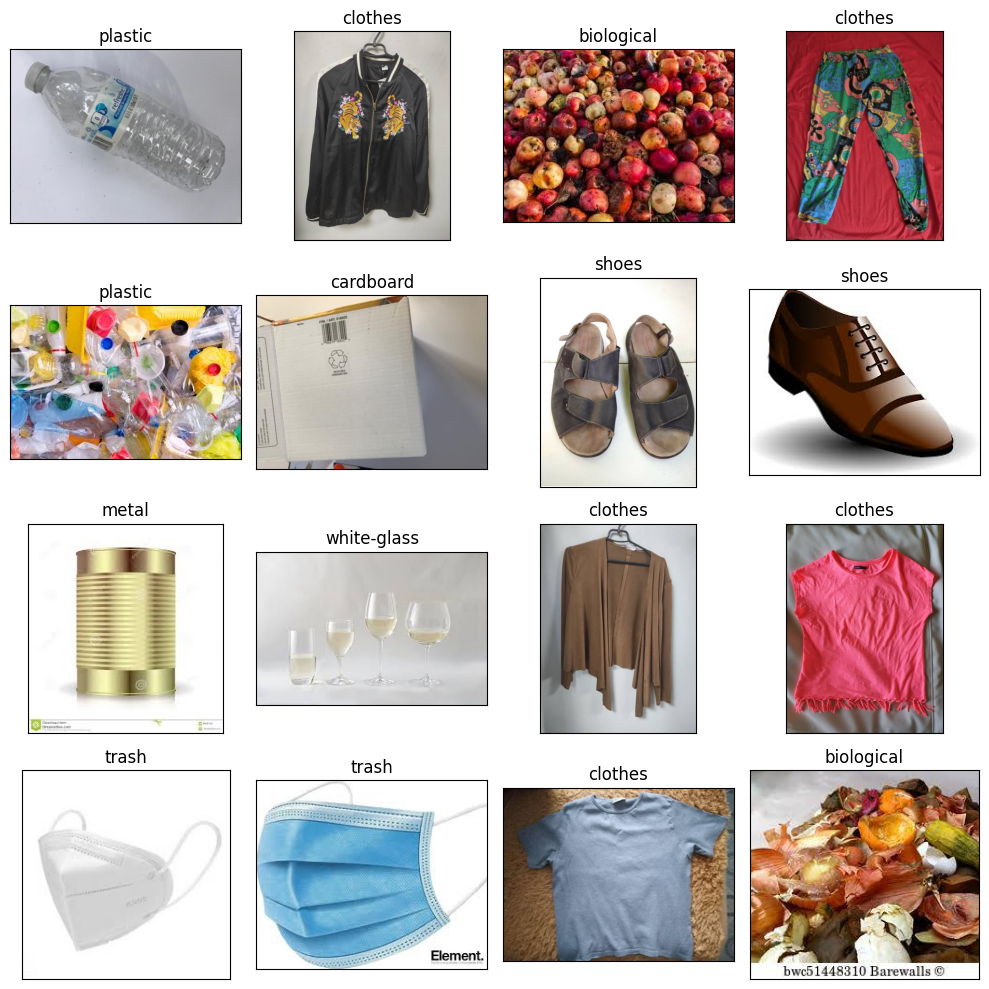

In [8]:
random_index = np.random.randint(0, len(image_df), 16)
print(random_index)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [9]:
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [10]:
train_df.shape

(12412, 2)

In [11]:
test_df.shape

(3103, 2)

In [12]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

In [13]:
BATCH_SIZE = 32
IMAGE_SIZE = (300, 300)

In [14]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 9930 validated image filenames belonging to 12 classes.
Found 2482 validated image filenames belonging to 12 classes.
Found 3103 validated image filenames belonging to 12 classes.


In [18]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
  #layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [19]:
#Loading pretrained model
pretrained_model=tf.keras.applications.ResNet50(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet',
        pooling='avg'
)

94765736/94765736 [==============================] - 0s 0us/step


In [20]:
pretrained_model.trainable = False

In [22]:
# Create checkpoint callback
checkpoint_path = "garbage_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [23]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

In [29]:
inputs=pretrained_model.inputs
x = resize_and_rescale(inputs)
x=Dense(256,activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)

outputs = Dense(12, activation='softmax')(x)

In [30]:
model=Model(inputs,outputs)

In [31]:
model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=2,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs",
                                    "garbage_classification"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/garbage_classification/20240123-065417
Epoch 1/2
311/311 [==============================] - 3188s 10s/step - loss: 0.7973 - accuracy: 0.7627 - val_loss: 0.2483 - val_accuracy: 0.9279
Epoch 2/2
311/311 [==============================] - 2669s 9s/step - loss: 0.2719 - accuracy: 0.9159 - val_loss: 0.1797 - val_accuracy: 0.9416


In [32]:
history.history

{'loss': [0.7972779870033264, 0.2719314992427826],
 'accuracy': [0.7627391815185547, 0.9159113764762878],
 'val_loss': [0.24828514456748962, 0.1797216534614563],
 'val_accuracy': [0.9278807640075684, 0.9415793418884277]}

In [33]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.19218
Test Accuracy: 93.91%


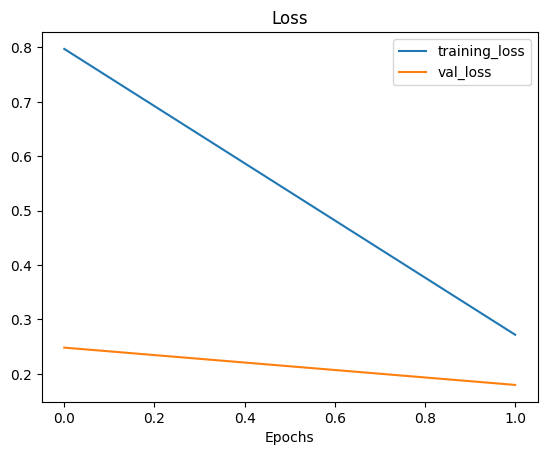

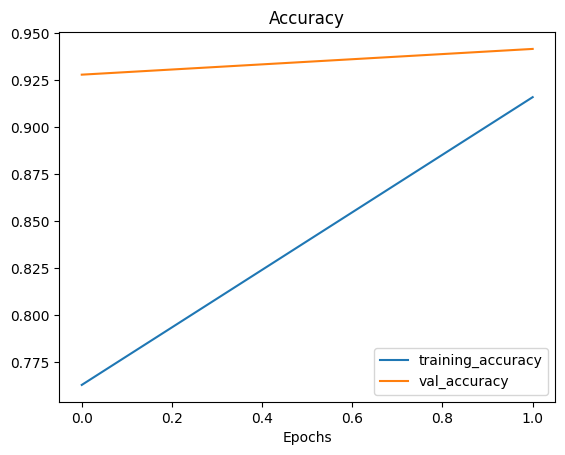

In [34]:
import matplotlib.pyplot as plt


loss = history.history['loss']
val_loss = history.history['val_loss']

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(len(history.history['loss']))

# Plot loss
plt.plot(epochs, loss, label='training_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

# Plot accuracy
plt.figure()
plt.plot(epochs, accuracy, label='training_accuracy')
plt.plot(epochs, val_accuracy, label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend();


In [35]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 10 predictions: {pred[:10]}')

97/97 [==============================] - 656s 7s/step
The first 10 predictions: ['green-glass', 'biological', 'green-glass', 'clothes', 'shoes', 'white-glass', 'shoes', 'clothes', 'clothes', 'metal']


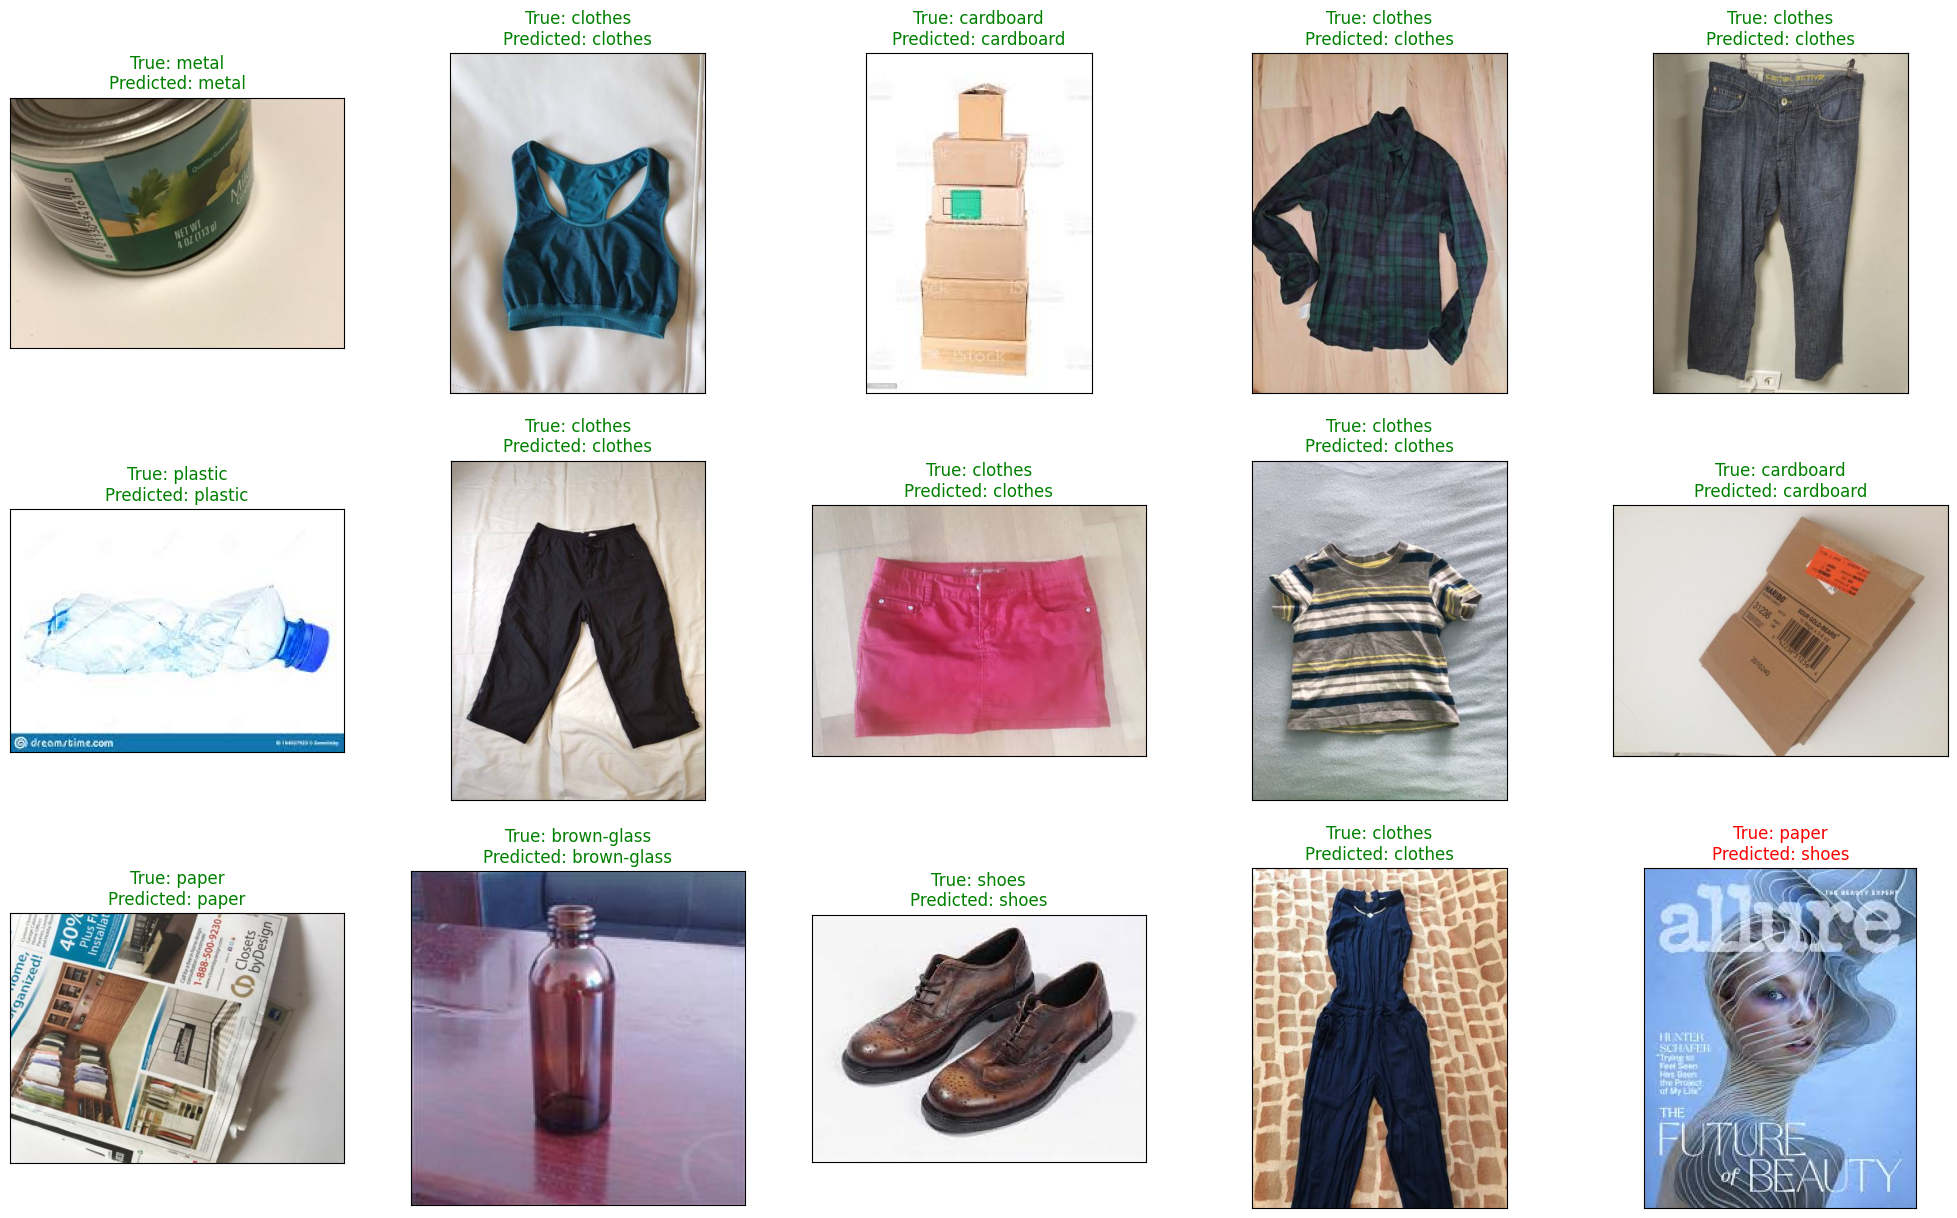

<Figure size 640x480 with 0 Axes>

In [36]:
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [37]:
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
battery,0.935644,0.974227,0.954545,194.000000
biological,0.904523,0.994475,0.947368,181.000000
brown-glass,0.924370,0.846154,0.883534,130.000000
cardboard,0.959538,0.954023,0.956772,174.000000
clothes,0.988960,0.988960,0.988960,1087.000000
green-glass,0.932836,0.954198,0.943396,131.000000
metal,0.795812,0.904762,0.846797,168.000000
paper,0.921182,0.907767,0.914425,206.000000
plastic,0.920863,0.711111,0.802508,180.000000
shoes,0.958225,0.963255,0.960733,381.000000


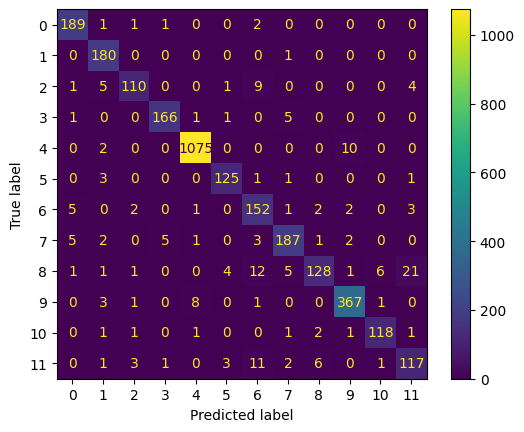

In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()